# Coronavirus/COVID-19 Timseries Forecasting

- [GitHub Repo](https://github.com/jirvingphd/playing-with-coronavirus-data)
- James M. Irivng, Ph.D.
- james.irving.phd@gmail.com

> **~~NOTE: DATA ACQUISITION IS BEING RE-WORKED IN "Exploring Options for Replacing Covid Tracking Project Data_08-2021.ipnynb"~~** -08/12/21

# Business Problem

- Covid-19 and the various strains that have since emerged has upended modern life and fundamental changed how we function as a society.
- Part of what has made it difficult to tackle the pandemic is due to differences between states, state laws/policies, and a lack of public understanding about the predictability of the surges in cases. 


### Goal

- The goal of this notebook is to produce a workflow for producing forecasts of the following metrics at least 1 week ahead of time. 
    - Confirmed Cases
    - Number of Deaths
    - ICU Capacity
    
- The stretch goal for the project is to create a streamlit dashboard for getting state-level forecasts for any state in the US, using fresh daily data.
    

### Methodology

- To select 3-5 prototypical states representing very different time courses/
- Initial Thoughts:
    - NY
    - TX
    - FL
    - MD
    - LA

- See `data_acquisition.py`> `FULL_WORKFLOW()` and `1_Replacing Covid Tracking Project - Simplified Workflow.ipynb` for details (for now)


# OBTAIN

In [1]:
RUN_FULL_WORKFLOW=True

In [2]:
import statsmodels
statsmodels.__version__

In [3]:
import statsmodels.tsa.api as tsa

In [4]:
# !pip install fsds
# !pip install pmdarima

from fsds.imports import *
import os,glob,sys,joblib
import re

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

plt.rcParams['figure.figsize'] = (12,6)
pd.set_option('display.max_columns',0)



fsds v0.3.2 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [5]:
%load_ext autoreload
%autoreload 2
import project_functions as fn
# import data_acquisition as da
# import coronavirus_functions as fn

## Data

> Data is stored as both separate csvs for each state as well as one big dictionary in a joblib file.

In [1]:
## Uncomment Cell to acquire new data
if RUN_FULL_WORKFLOW:
    df_states,STATES = fn.data.FULL_WORKFLOW()
else:
    print(f"[i] Using previously downloaded data...")
    df_states = pd.read_csv('data/combined_us_states_full_data.csv')
    STATES = joblib.load('data/STATE_DICT.joblib')

display(df_states.head())
STATES.keys()

NameError: name 'RUN_FULL_WORKFLOW' is not defined

# EDA

## Matching Hospital columns

#### Columns to find from the covid tracking project dataset: 

- "hospitalizedCurrently"/"hospitalizedCumulative"
- "inIcuCurrently","inIcuCumulative"
- "onVentilatorCurrently","onVentilatorCumulative"

In [7]:
compare_state='MD'

In [8]:
## OLD DATA
covid = fn.covid.CovidTrackingProject(verbose=True)
# covid

old_df = covid.df_states.copy()
old_df.index.name='Date'
old_md = old_df.groupby('state').get_group(compare_state).copy()
# old_md = old_md.set_index('date').sort_index()
old_md

[i] DOWNLOADING DATASETS FROM COVID TRACKING PROJECT
	https://covidtracking.com/data
	- File saved as: "New Data/states_metadata.csv"
ERROR
	- File saved as: "New Data/us.csv"
	- File saved as: "New Data/states.csv"


,state,fips,positive,negative,death,recovered,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,pending,dataQualityGrade,lastUpdateEt,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,positiveIncrease,totalTestResults,totalTestResultsIncrease,deathIncrease,hospitalizedIncrease
Date,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-07,MD,24,387319.0,3034546.0,7955.0,9703.0,818.0,35651.0,215.0,NaN,NaN,NaN,NaN,NaN,3/7/2021 10:00,8097590.0,472716.0,NaN,387319.0,709,8097590.0,33128,14,79
2021-03-06,MD,24,386610.0,3032496.0,7941.0,9703.0,830.0,35572.0,230.0,NaN,NaN,NaN,NaN,NaN,3/6/2021 10:00,8064462.0,471762.0,NaN,386610.0,932,8064462.0,40384,11,194
2021-03-05,MD,24,385678.0,3024949.0,7930.0,9701.0,849.0,35378.0,229.0,NaN,NaN,NaN,NaN,NaN,3/5/2021 10:00,8024078.0,470625.0,NaN,385678.0,913,8024078.0,41728,8,74
2021-03-04,MD,24,384765.0,3018120.0,7922.0,9691.0,856.0,35304.0,216.0,NaN,NaN,NaN,NaN,NaN,3/4/2021 10:00,7982350.0,469489.0,NaN,384765.0,809,7982350.0,33723,3,81
2021-03-03,MD,24,383956.0,3012179.0,7919.0,9685.0,863.0,35223.0,228.0,NaN,NaN,NaN,NaN,NaN,3/3/2021 10:00,7948627.0,468532.0,NaN,383956.0,786,7948627.0,31296,14,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-09,MD,24,5.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2,NaN,0,0,0
2020-03-08,MD,24,3.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,NaN,0,0,0
2020-03-07,MD,24,3.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,NaN,0,0,0


In [9]:
def get_state(STATES, state='NY',drop_cols=True,drop_exprs=['coverage','denominator',
                                                           'numerator']):
    df_state= STATES[state].copy()
    
    
    if drop_cols:
        cols_to_drop = []
        for expr in drop_exprs:
            cols_to_drop.extend([c for c in df_state.columns if expr.lower() in c.lower()])
        df_state = df_state.drop(columns=cols_to_drop)
        
    return df_state

In [10]:
md = get_state(STATES,'MD',drop_exprs=[])
new_md = md.loc[old_df.index[-1]:old_df.index[0]].copy()
new_md

,Cases,Deaths,adult_icu_bed_utilization_coverage,inpatient_beds,staffed_adult_icu_bed_occupancy,inpatient_beds_used_covid,inpatient_beds_utilization_coverage,deaths_covid_coverage,percent_of_inpatients_with_covid,inpatient_beds_utilization,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,adult_icu_bed_utilization_numerator,inpatient_bed_covid_utilization_denominator,inpatient_beds_used,total_pediatric_patients_hospitalized_confirmed_covid,inpatient_beds_coverage,staffed_adult_icu_bed_occupancy_coverage,percent_of_inpatients_with_covid_numerator,deaths_covid,adult_icu_bed_covid_utilization_coverage,adult_icu_bed_utilization_denominator,inpatient_bed_covid_utilization_coverage,percent_of_inpatients_with_covid_denominator,inpatient_bed_covid_utilization_numerator,total_adult_patients_hospitalized_confirmed_covid,inpatient_beds_utilization_denominator,total_staffed_adult_icu_beds_coverage,adult_icu_bed_covid_utilization_denominator,total_adult_patients_hospitalized_confirmed_and_suspected_covid,adult_icu_bed_covid_utilization,adult_icu_bed_covid_utilization_numerator,inpatient_beds_used_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_adult_patients_hospitalized_confirmed_covid_coverage,percent_of_inpatients_with_covid_coverage,inpatient_beds_utilization_numerator,total_pediatric_patients_hospitalized_confirmed_covid_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,inpatient_bed_covid_utilization,inpatient_beds_used_coverage,total_staffed_adult_icu_beds,adult_icu_bed_utilization
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0,0,NaN,6.0,NaN,0.0,1.0,1,0.000000,0.666667,NaN,NaN,6.0,4.0,NaN,1,0,0.0,0.0,NaN,NaN,1.0,4.0,0.0,NaN,6.0,0,NaN,NaN,NaN,NaN,1,0,0,1.0,4.0,0,0,0.000000,1,NaN,NaN
2020-03-02,0,0,NaN,6.0,NaN,0.0,1.0,1,0.000000,0.666667,NaN,NaN,6.0,4.0,NaN,1,0,0.0,0.0,NaN,NaN,1.0,4.0,0.0,NaN,6.0,0,NaN,NaN,NaN,NaN,1,0,0,1.0,4.0,0,0,0.000000,1,NaN,NaN
2020-03-03,0,0,NaN,6.0,NaN,0.0,1.0,1,0.000000,0.666667,NaN,NaN,6.0,4.0,NaN,1,0,0.0,6.0,NaN,NaN,1.0,4.0,0.0,NaN,6.0,0,NaN,NaN,NaN,NaN,1,0,0,1.0,4.0,0,0,0.000000,1,NaN,NaN
2020-03-04,0,0,NaN,6.0,NaN,0.0,1.0,1,0.000000,0.666667,NaN,NaN,6.0,4.0,NaN,1,0,0.0,0.0,NaN,NaN,1.0,4.0,0.0,NaN,6.0,0,NaN,NaN,NaN,NaN,1,0,0,1.0,4.0,0,0,0.000000,1,NaN,NaN
2020-03-05,0,0,NaN,6.0,NaN,0.0,1.0,1,0.000000,0.666667,NaN,NaN,6.0,4.0,NaN,1,0,0.0,0.0,NaN,NaN,1.0,4.0,0.0,NaN,6.0,0,NaN,NaN,NaN,NaN,1,0,0,1.0,4.0,0,0,0.000000,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-03,383956,7919,61.0,12268.0,1031.0,1108.0,61.0,60,0.115887,0.784806,15.0,1031.0,12157.0,9628.0,11.0,61,61,1108.0,10.0,60.0,1396.0,60.0,9561.0,1108.0,823.0,12268.0,61,1357.0,1093.0,0.176861,240.0,60,60,61,60.0,9628.0,60,60,0.091141,61,1396.0,0.738539
2021-03-04,384765,7922,61.0,12191.0,1023.0,1101.0,61.0,60,0.114699,0.792798,15.0,1023.0,12080.0,9665.0,10.0,61,61,1101.0,12.0,60.0,1372.0,60.0,9599.0,1101.0,808.0,12191.0,61,1333.0,1086.0,0.179295,239.0,60,60,61,60.0,9665.0,60,60,0.091142,61,1372.0,0.745627
2021-03-05,385678,7930,61.0,12097.0,1025.0,1063.0,61.0,60,0.111907,0.790692,11.0,1025.0,11986.0,9565.0,9.0,61,61,1063.0,11.0,60.0,1386.0,60.0,9499.0,1063.0,801.0,12097.0,61,1347.0,1052.0,0.183370,247.0,60,60,61,60.0,9565.0,60,60,0.088687,61,1386.0,0.739538


### Compare Plots

In [11]:
# ax = old_md['positive'].plot(label='Old')
# new_md['Cases'].plot(ax=ax,label='New')
# ax.legend()

In [12]:
# new_md[[c for c in new_md.columns if 'icu' in c.lower()]]

In [13]:
from sklearn import metrics
# sns.set(context='notebook')
# plt.style.use('fivethirtyeight')
def compare_old_vs_new_cols(old_df,new_df,old_col = 'hospitalizedCurrently',
                            top_n=3):
    ## Compare cols vs inIcuCumulative 
    results = [['Old Col','New Col','RMSE']]
    FIGURES = {}

    for col in new_df.columns:
#         print('---'*20)
#         print(f"{col}")
        fig, ax = plt.subplots(figsize=(8,4))
        fig.suptitle(f"{col} vs {old_col}")
        
        ## Save columns as vars and calc rmse
        data_concat = pd.merge(old_df[old_col].reset_index(),
                               new_md[col].reset_index(), on='Date',
                               how='outer')
        data_concat = data_concat.set_index("Date").fillna(0)
        old_data = data_concat[old_col].copy()
        new_data = data_concat[col].copy()
        
        ## calc andd save metrics
        rmse = metrics.mean_squared_error(old_data,new_data,squared=False)
        results.append([old_col,col,rmse])
        
#         res = pd.DataFrame(results[1:],columns=results[0])
        old_data.plot(label='Old',ax=ax,lw=3)
        new_data.plot(ax=ax,label='New',ls=':')
        fig.suptitle(f"{old_col} vs {col} (RMSE={round(rmse,2)})",y=1.02)
        ax.legend()
        
        fig.tight_layout()
        FIGURES[col] = fig
        plt.close(1)
#         del fig
#         plt.show()
#         print('\n\n')
        
        
    try: 
        res = pd.DataFrame(results[1:],columns=results[0]).sort_values('RMSE')
    except Exception as e:
        print("[!] Error",e)
        print('Returning list instead of dataframe.')
        return  results

    order = list(res["New Col"].head(top_n))
    for top_col in order:
        print('---'*20)
        print(f"{top_col}")
        display(FIGURES[top_col])
        print('\n\n')

    return res


------------------------------------------------------------
Deaths


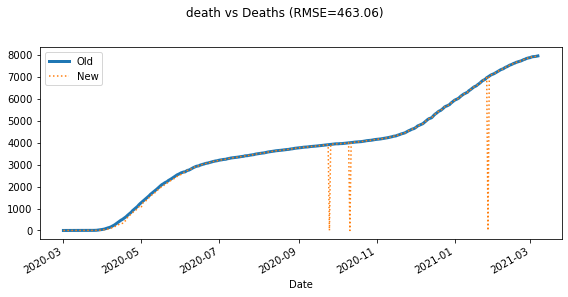




------------------------------------------------------------
inpatient_beds_used_covid


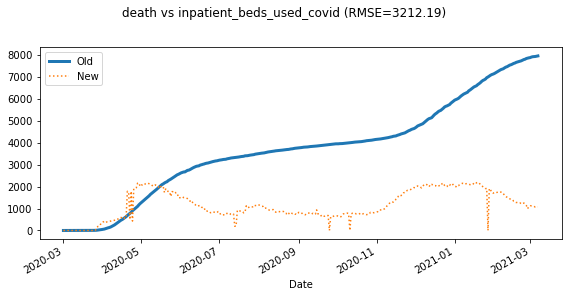




------------------------------------------------------------
percent_of_inpatients_with_covid_numerator


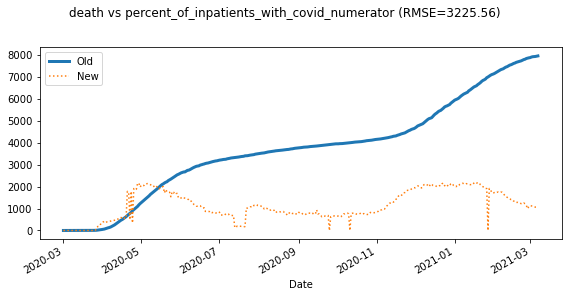

In [14]:
res = compare_old_vs_new_cols(old_md,new_md,old_col='death')
# res.sort_values()

In [15]:
res.sort_values('RMSE').head()

,Old Col,New Col,RMSE
1,death,Deaths,463.056015
5,death,inpatient_beds_used_covid,3212.193172
17,death,percent_of_inpatients_with_covid_numerator,3225.564276
23,death,inpatient_bed_covid_utilization_numerator,3225.849805
28,death,total_adult_patients_hospitalized_confirmed_an...,3365.813201


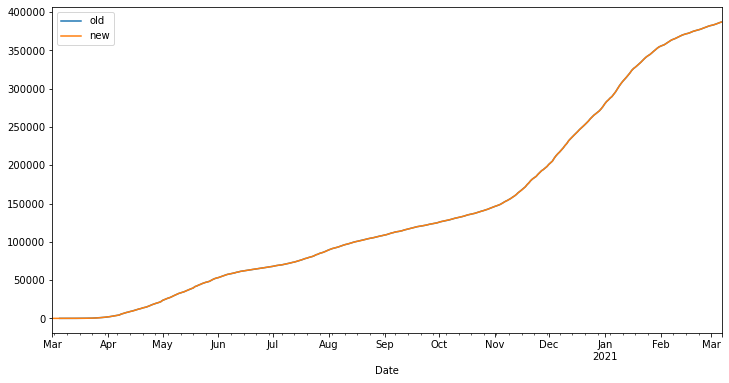

In [16]:
## Matched positive -> Cases
ax = old_md['positive'].plot(label='old')
new_md['Cases'].plot(label='new', ax=ax)
ax.legend()

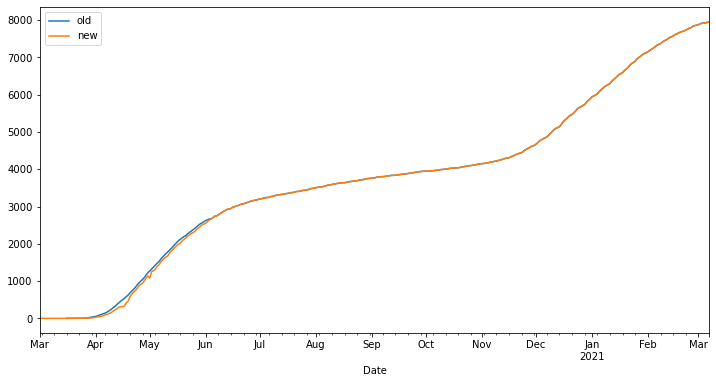

In [17]:
## Matched death -> Deaths
ax = old_md['death'].plot(label='old')
new_md['Deaths'].plot(label='new', ax=ax)
ax.legend()

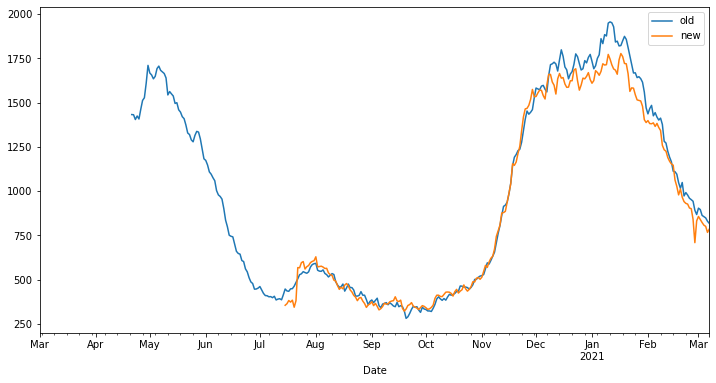

In [18]:
## Matched hospitalizedCurrenlty
ax = old_md['hospitalizedCurrently'].plot(label='old')
new_md['total_adult_patients_hospitalized_confirmed_covid'].plot(label='new',
                                                                ax=ax)
ax.legend()

In [19]:
res.sort_values('RMSE').head()

,Old Col,New Col,RMSE
1,death,Deaths,463.056015
5,death,inpatient_beds_used_covid,3212.193172
17,death,percent_of_inpatients_with_covid_numerator,3225.564276
23,death,inpatient_bed_covid_utilization_numerator,3225.849805
28,death,total_adult_patients_hospitalized_confirmed_an...,3365.813201


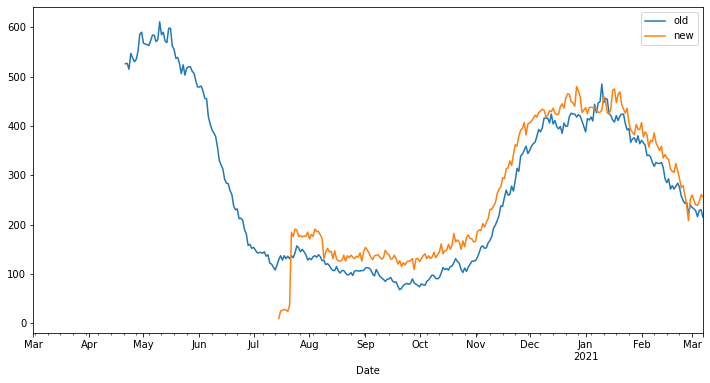

In [20]:
## Matched inIcuCurrently
ax = old_md['inIcuCurrently'].plot(label='old')
new_md['adult_icu_bed_covid_utilization_numerator'].plot(label='new',
                                                                ax=ax)
ax.legend()

In [21]:
# compare_old_vs_new_cols(old_md,new_md,old_col='inIcuCurrently')

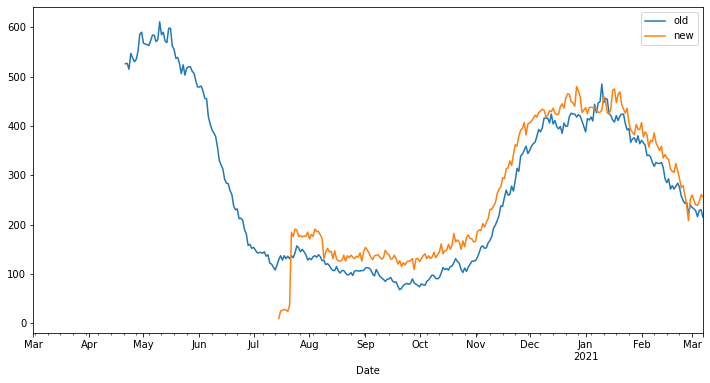

In [22]:
ax = old_md['inIcuCurrently'].plot(label='old')
new_md['adult_icu_bed_covid_utilization_numerator'].plot(ax=ax,label='new')
ax.legend()

### MATCHING COLUMN MAPPER
- old "`death`"== new "`Deaths`
- old "`positive`"== new "`Cases`
- old "`hospitalizedCurrently`" ==`adult_icu_bed_covid_utilization_numerator`
    
- old "`inIcuCurrently`" == `adult_icu_bed_covid_utilization_numerator`
       

In [23]:
## making mapper dict to rename new columns
new_to_match_old_map = {
    'Deaths':'death',
    'Cases':'positive',
    'total_adult_patients_hospitalized_confirmed_covid':'hospitalizedCurrently',
'adult_icu_bed_covid_utilization_numerator':'inIcuCurrently'}

In [24]:
new_md[list(new_to_match_old_map.keys())]

,Deaths,Cases,total_adult_patients_hospitalized_confirmed_covid,adult_icu_bed_covid_utilization_numerator
Date,,,,
2020-03-01,0,0,NaN,NaN
2020-03-02,0,0,NaN,NaN
2020-03-03,0,0,NaN,NaN
2020-03-04,0,0,NaN,NaN
2020-03-05,0,0,NaN,NaN
...,...,...,...,...
2021-03-03,7919,383956,823.0,240.0
2021-03-04,7922,384765,808.0,239.0
2021-03-05,7930,385678,801.0,247.0


In [25]:
old_md[list(new_to_match_old_map.values())]

,death,positive,hospitalizedCurrently,inIcuCurrently
Date,,,,
2021-03-07,7955.0,387319.0,818.0,215.0
2021-03-06,7941.0,386610.0,830.0,230.0
2021-03-05,7930.0,385678.0,849.0,229.0
2021-03-04,7922.0,384765.0,856.0,216.0
2021-03-03,7919.0,383956.0,863.0,228.0
...,...,...,...,...
2020-03-09,NaN,5.0,NaN,NaN
2020-03-08,NaN,3.0,NaN,NaN
2020-03-07,NaN,3.0,NaN,NaN


## Processing All `STATES` hospital data

In [26]:
## making mapper dict to rename new columns
new_to_final_names = {
    'Deaths':'Deaths',
    'Cases':'Cases',
    'total_adult_patients_hospitalized_confirmed_covid':'Hospitalized Currently',
'adult_icu_bed_covid_utilization_numerator':'ICU-Covid Currently'}
list(new_to_final_names.keys())

['Deaths',
 'Cases',
 'total_adult_patients_hospitalized_confirmed_covid',
 'adult_icu_bed_covid_utilization_numerator']

In [27]:
import datetime as dt
today = dt.date.today()
today

datetime.date(2021, 9, 1)

In [28]:
# len(np.unique(list(STATES.keys())))
# toda
date_index = pd.date_range(pd.Timestamp('2020-01-22 00:00:00'),today)
date_index.name="Date"
date_index

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2021-08-23', '2021-08-24', '2021-08-25', '2021-08-26',
               '2021-08-27', '2021-08-28', '2021-08-29', '2021-08-30',
               '2021-08-31', '2021-09-01'],
              dtype='datetime64[ns]', name='Date', length=589, freq='D')

In [29]:
# df_time = pd.DataFrame(index=date_index)
# df_time

In [30]:
# final_states.join(md)
# final_states

In [31]:
STATES['NY']

,Cases,Deaths,adult_icu_bed_utilization_coverage,inpatient_beds,staffed_adult_icu_bed_occupancy,inpatient_beds_used_covid,inpatient_beds_utilization_coverage,deaths_covid_coverage,percent_of_inpatients_with_covid,inpatient_beds_utilization,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,adult_icu_bed_utilization_numerator,inpatient_bed_covid_utilization_denominator,inpatient_beds_used,total_pediatric_patients_hospitalized_confirmed_covid,inpatient_beds_coverage,staffed_adult_icu_bed_occupancy_coverage,percent_of_inpatients_with_covid_numerator,deaths_covid,adult_icu_bed_covid_utilization_coverage,adult_icu_bed_utilization_denominator,inpatient_bed_covid_utilization_coverage,percent_of_inpatients_with_covid_denominator,inpatient_bed_covid_utilization_numerator,total_adult_patients_hospitalized_confirmed_covid,inpatient_beds_utilization_denominator,total_staffed_adult_icu_beds_coverage,adult_icu_bed_covid_utilization_denominator,total_adult_patients_hospitalized_confirmed_and_suspected_covid,adult_icu_bed_covid_utilization,adult_icu_bed_covid_utilization_numerator,inpatient_beds_used_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_adult_patients_hospitalized_confirmed_covid_coverage,percent_of_inpatients_with_covid_coverage,inpatient_beds_utilization_numerator,total_pediatric_patients_hospitalized_confirmed_covid_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,inpatient_bed_covid_utilization,inpatient_beds_used_coverage,total_staffed_adult_icu_beds,adult_icu_bed_utilization
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-14,557,5,NaN,2145.0,NaN,6.0,1.0,1,0.000000,0.906667,NaN,NaN,2145.0,68.0,NaN,2,0,0.0,0.0,NaN,NaN,2.0,68.0,6.0,NaN,75.0,0,NaN,NaN,NaN,NaN,2,0,0,1.0,68.0,0,0,0.002797,1,NaN,NaN
2020-03-15,633,10,NaN,1960.0,NaN,88.0,3.0,3,0.055034,0.815816,NaN,NaN,1960.0,1599.0,NaN,3,0,88.0,0.0,NaN,NaN,3.0,1599.0,88.0,NaN,1960.0,0,NaN,NaN,NaN,NaN,3,0,0,3.0,1599.0,0,0,0.044898,3,NaN,NaN
2020-03-16,961,21,NaN,2161.0,NaN,97.0,4.0,4,0.057876,0.775567,NaN,NaN,2161.0,1676.0,NaN,4,0,97.0,2.0,NaN,NaN,4.0,1676.0,97.0,NaN,2161.0,0,NaN,NaN,NaN,NaN,4,0,0,4.0,1676.0,0,0,0.044887,4,NaN,NaN
2020-03-16,961,21,NaN,2161.0,NaN,97.0,4.0,4,0.057876,0.775567,NaN,NaN,2161.0,1676.0,NaN,4,0,97.0,2.0,NaN,NaN,4.0,1676.0,97.0,NaN,2161.0,0,NaN,NaN,NaN,NaN,4,0,0,4.0,1676.0,0,0,0.044887,4,NaN,NaN
2020-03-17,1407,35,NaN,2161.0,NaN,128.0,4.0,4,0.076100,0.778343,NaN,NaN,2161.0,1682.0,NaN,4,0,128.0,1.0,NaN,NaN,4.0,1682.0,128.0,NaN,2161.0,0,NaN,NaN,NaN,NaN,4,0,0,4.0,1682.0,0,0,0.059232,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-12,2192224,53828,209.0,50847.0,3469.0,2073.0,209.0,200,0.051725,0.794639,60.0,3469.0,50264.0,40405.0,29.0,209,209,2073.0,17.0,200.0,5185.0,200.0,40077.0,2073.0,1565.0,50847.0,209,5081.0,2013.0,0.072427,368.0,200,200,209,200.0,40405.0,200,200,0.041242,209,5185.0,0.669045
2021-08-13,2196866,53840,209.0,50855.0,3432.0,2176.0,209.0,200,0.054947,0.784289,66.0,3432.0,50273.0,39885.0,32.0,209,209,2176.0,13.0,200.0,5182.0,200.0,39602.0,2176.0,1662.0,50855.0,209,5078.0,2110.0,0.078377,398.0,200,200,209,200.0,39885.0,200,200,0.043284,209,5182.0,0.662293
2021-08-14,2201468,53855,209.0,50849.0,3382.0,2119.0,209.0,200,0.055441,0.757458,69.0,3382.0,50267.0,38516.0,34.0,209,209,2119.0,18.0,200.0,5176.0,200.0,38221.0,2119.0,1675.0,50849.0,209,5072.0,2050.0,0.075710,384.0,200,200,209,200.0,38516.0,200,200,0.042155,209,5176.0,0.653400


In [32]:
new_to_final_names

{'Deaths': 'Deaths',
 'Cases': 'Cases',
 'total_adult_patients_hospitalized_confirmed_covid': 'Hospitalized Currently',
 'adult_icu_bed_covid_utilization_numerator': 'ICU-Covid Currently'}

### TO DO: Add Cumulative Cols - new cols to loopf or FINAL_STATE

In [100]:
## saving final version of dataset
FINAL_STATES = {} #pd.DataFrame(index=date_index)

for state, state_df in STATES.items():
    
    state_df = state_df[list(new_to_final_names.keys())].copy().sort_index()
    state_df = state_df.rename(new_to_final_names,axis=1)
    
    ## Renamaed columns to process
    hospital_cols = ['Hospitalized Currently','ICU-Covid Currently']
    cumulative_cols = ['Deaths','Cases'] # cols to diff
    
    ## fill hospital cols with 0
    state_df[hospital_cols] = state_df[hospital_cols].fillna(0)

    for col in cumulative_cols:
        state_df[f"{col}-New"] = state_df[col].diff().fillna(0)
    state_df

#     state_df.columns = [f"{state}: {c}" for c in state_df.columns]
    FINAL_STATES[state]= state_df.copy()


    FINAL_STATES.keys()

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

In [105]:
## save FINAL_STATES
joblib.dump(FINAL_STATES,'data/FINAL_STATES.joblib',compress=3)

['data/FINAL_STATES.joblib']

In [101]:
FINAL_STATES['MD']

,Deaths,Cases,Hospitalized Currently,ICU-Covid Currently,Deaths-New,Cases-New
Date,,,,,,
2020-03-01,0,0,0.0,0.0,0.0,0.0
2020-03-02,0,0,0.0,0.0,0.0,0.0
2020-03-03,0,0,0.0,0.0,0.0,0.0
2020-03-04,0,0,0.0,0.0,0.0,0.0
2020-03-05,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2021-08-12,9873,477117,478.0,152.0,3.0,1047.0
2021-08-13,9878,478067,514.0,156.0,5.0,950.0
2021-08-14,9887,479083,548.0,151.0,9.0,1016.0


In [107]:
DF = pd.concat(FINAL_STATES)
DF

Deaths  Cases  ...  Deaths-New  Cases-New
   Date                       ...                       
AK 2020-03-23       0     39  ...         0.0        0.0
   2020-03-24       0     43  ...         0.0        4.0
   2020-03-25       1     50  ...         1.0        7.0
   2020-03-26       1     64  ...         0.0       14.0
   2020-03-27       1     75  ...         0.0       11.0
...               ...    ...  ...         ...        ...
WY 2021-08-13     793  68272  ...         0.0      315.0
   2021-08-14     793  68272  ...         0.0        0.0
   2021-08-15     793  68272  ...         0.0        0.0
   2021-08-16     793  68944  ...         0.0      672.0
   2021-08-17     809  69356  ...        16.0      412.0

[27914 rows x 6 columns]

# EDA - Comparing States

## BOOKMARK 09/01/21

## FL

In [102]:
FL = FINAL_STATES['FL'].copy()
FL

,Deaths,Cases,Hospitalized Currently,ICU-Covid Currently,Deaths-New,Cases-New
Date,,,,,,
2020-03-12,2,30,0.0,0.0,0.0,0.0
2020-03-13,2,50,0.0,0.0,0.0,20.0
2020-03-13,2,50,0.0,0.0,0.0,0.0
2020-03-14,2,76,0.0,0.0,0.0,26.0
2020-03-15,3,100,0.0,0.0,1.0,24.0
...,...,...,...,...,...,...
2021-08-13,40766,2920749,15632.0,3319.0,1071.0,151764.0
2021-08-14,40766,2920749,15634.0,3393.0,0.0,0.0
2021-08-15,40766,2920749,15985.0,3476.0,0.0,0.0


In [103]:
## first non-null hospital timestamps
first_ts = FL[FL['Hospitalized Currently'].notna()].index[0]
first_ts

Timestamp('2020-03-12 00:00:00')

### Calc Delta Cases/Deaths

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

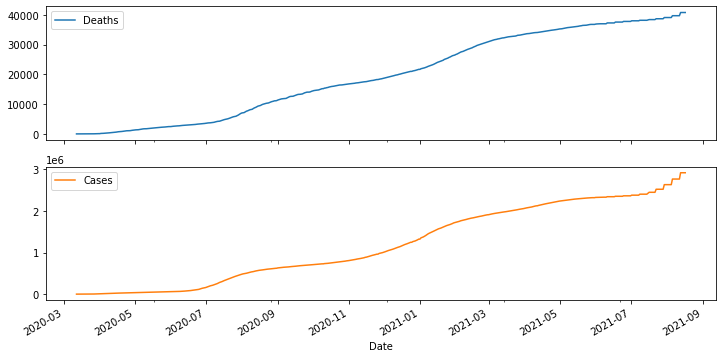

In [37]:
cumulative_cols = ['Deaths','Cases']
FL[cumulative_cols].plot(subplots=True)

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

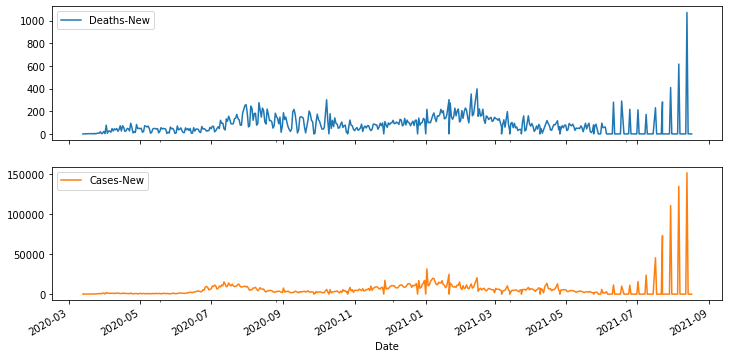

In [38]:
## Calcualting New/Delta-Columns
cumulative_cols = ['Deaths','Cases']
for col in cumulative_cols:
    FL[f"{col}-New"] = FL[col].diff()
FL[[c for c in FL.columns if 'New' in c]].plot(subplots=True)

In [39]:
import plotly
plotly.__version__

'5.3.1'

<AxesSubplot:>

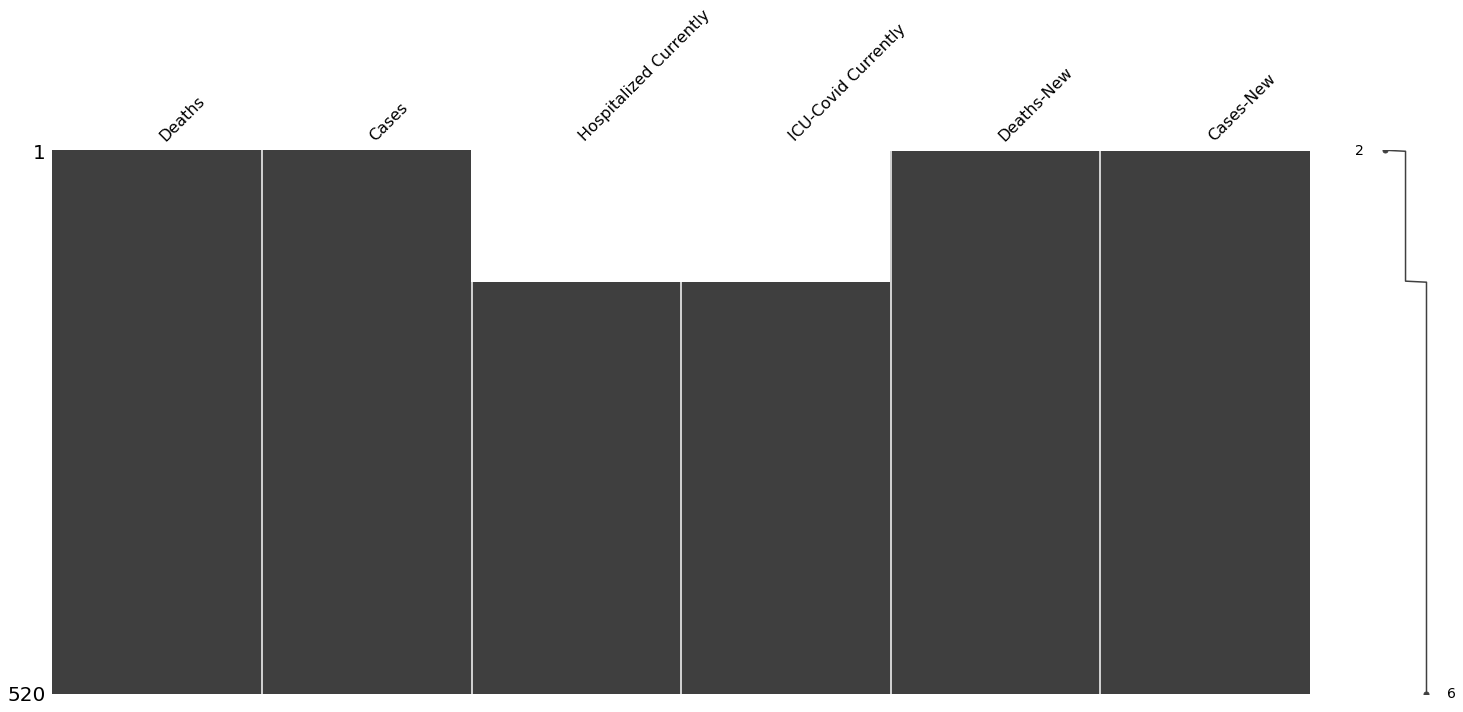

In [44]:
import missingno
missingno.matrix(FL)

In [59]:
# px.imshow(FL.isna(),template='plotly_dark',color_continuous_scale="Reds")

In [41]:
plot_cols = FL.drop(columns=cumulative_cols).columns
plot_cols

Index(['Hospitalized Currently', 'ICU-Covid Currently', 'Deaths-New',
       'Cases-New'],
      dtype='object')

In [49]:
pfig = px.line(FL,y=plot_cols,width=1000,title="FL Data")
pfig.add_vline(first_ts,line_width=3,line_dash="dash",name='Start')
pfig.show()

In [43]:
raise Exception('end of 09/01/21, though below code is still good.')

Exception: end of 09/01/21, though below code is still good.

# Time Series Modeling

In [60]:
### FORECAST SPECIFIC FUNCTIONS
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sms
import statsmodels.tsa.api as tsa
from pmdarima import auto_arima

## MD

In [61]:
state = "MD"
df_state = FINAL_STATES[state].loc['08-2020':].copy()
# df_state = df_state.interpolate('time')
df_state['Deaths-New'] = df_state['Deaths'].diff()
df_state['Cases-New'] = df_state['Cases'].diff()
df_state = df_state.resample('D').sum()

print(df_state.isna().sum())
df_state

Deaths                    0
Cases                     0
Hospitalized Currently    0
ICU-Covid Currently       0
Deaths-New                0
Cases-New                 0
dtype: int64


,Deaths,Cases,Hospitalized Currently,ICU-Covid Currently,Deaths-New,Cases-New
Date,,,,,,
2020-08-01,3506,89365,629.0,171.0,0.0,0.0
2020-08-02,3515,90274,572.0,180.0,9.0,909.0
2020-08-03,3523,91144,574.0,176.0,8.0,870.0
2020-08-04,3530,91854,576.0,191.0,7.0,710.0
2020-08-05,3536,92426,571.0,186.0,6.0,572.0
...,...,...,...,...,...,...
2021-08-12,9873,477117,478.0,152.0,3.0,1047.0
2021-08-13,9878,478067,514.0,156.0,5.0,950.0
2021-08-14,9887,479083,548.0,151.0,9.0,1016.0


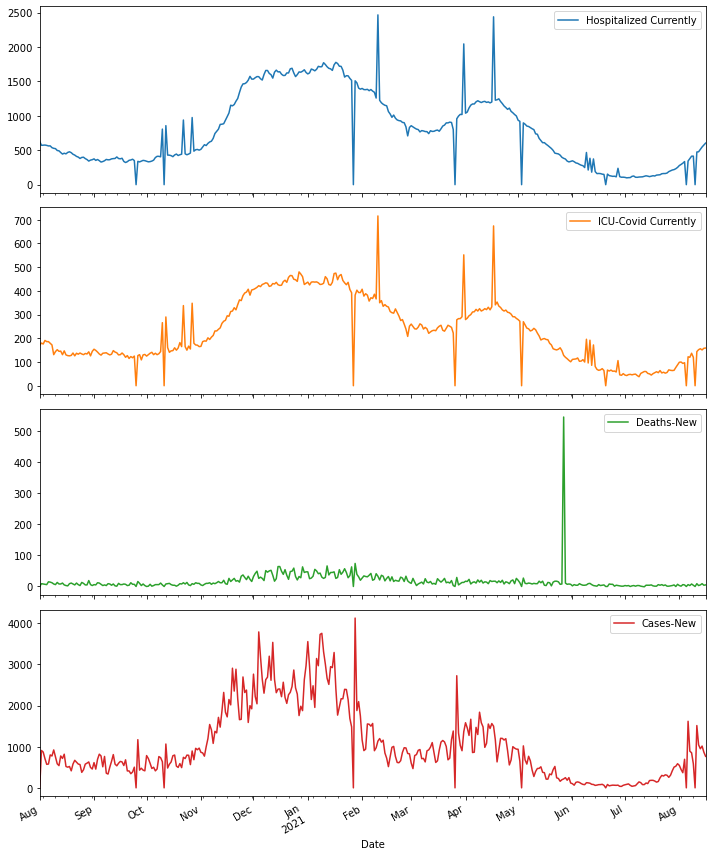

In [62]:
model_cols = ['Hospitalized Currently','ICU-Covid Currently',
              'Deaths-New','Cases-New'
             ]

## visualize
ax = df_state[model_cols].plot(subplots=True, figsize=(10,12))
plt.tight_layout();

#### Data Quality Issues
- There are strong spikes +/- that are not likely to be real values.

### MD - Cases-New

Text(0, 0.5, 'Cases-New')

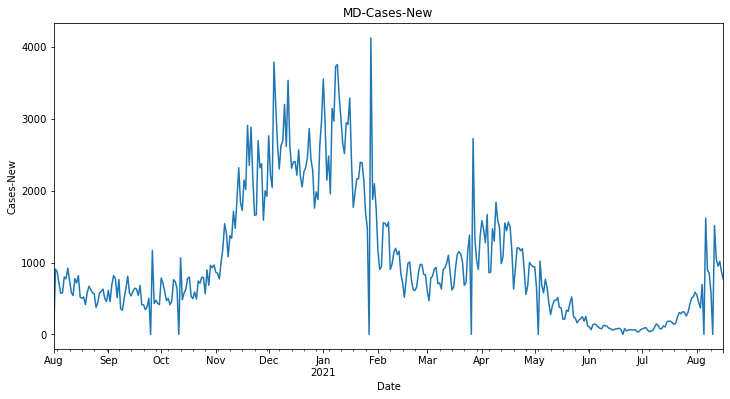

In [63]:
col = 'Cases-New'
ts = df_state[col].copy()
ax = ts.plot(title=f"{state}-{col}");
ax.set_ylabel(col)

#### Train Test Split

Using a cutoff index of -30, which = 07-18-2021


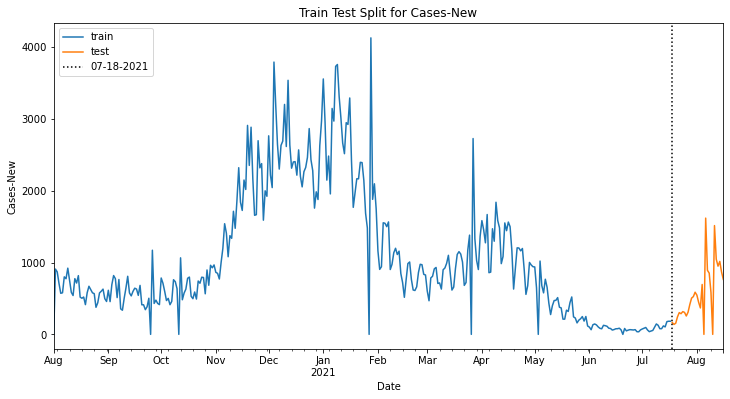

In [64]:
train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

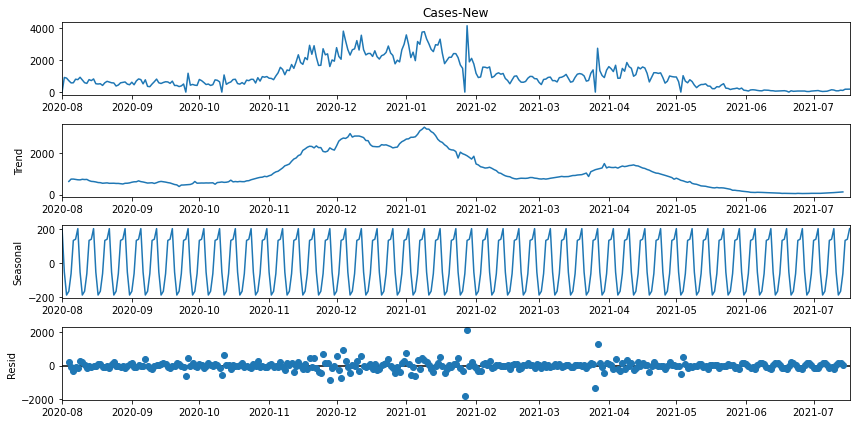

In [65]:
## Get Decomposed time sereis
decomp = tsa.seasonal_decompose(train)
decomp.plot();

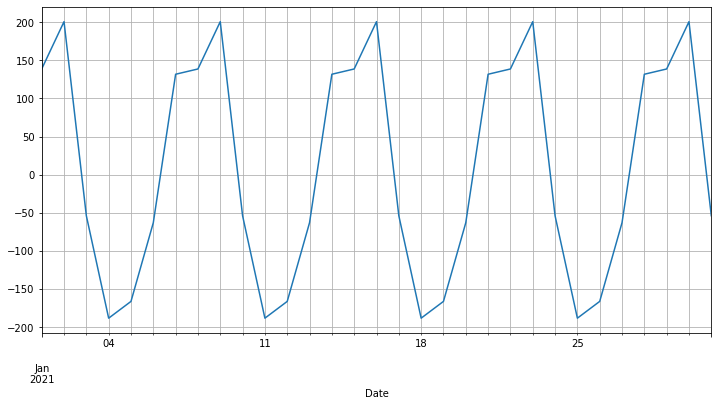

In [66]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-3.117319,15,328,0.025298,True,True


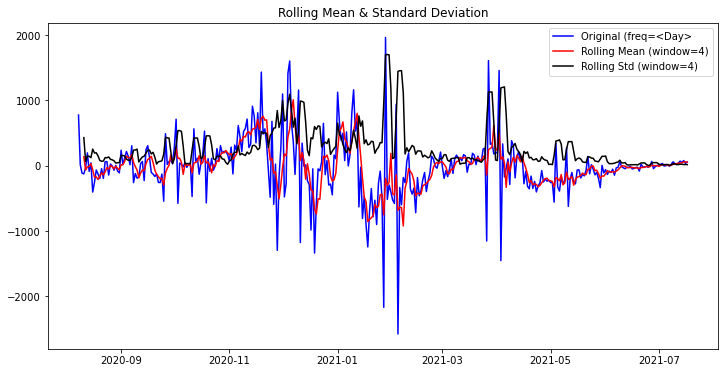

In [67]:
fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

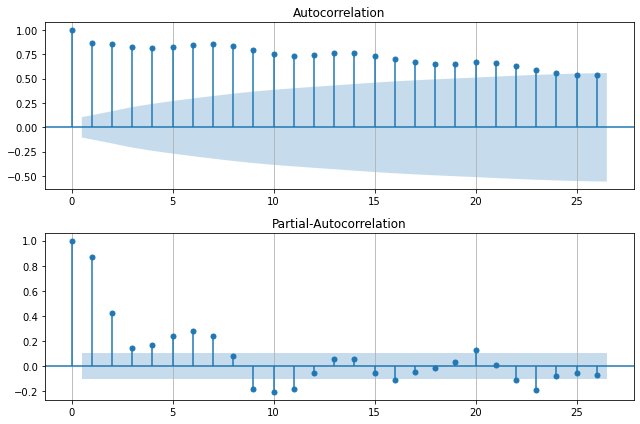

In [68]:
fn.modeling.plot_acf_pacf(train,);

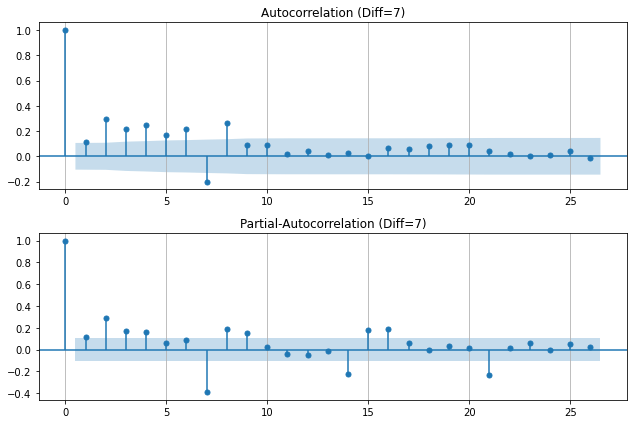

In [69]:
fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [70]:
from pmdarima import auto_arima

auto_model = auto_arima(train,m=7,trace=True,D=1,
                        start_p=0, start_q=0,
                        start_P=0, start_Q=0)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=5196.190, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=5160.327, Time=0.39 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=5172.880, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=5194.361, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=5193.423, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=5155.554, Time=0.68 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=5155.737, Time=1.20 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=5153.795, Time=0.57 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=5151.984, Time=0.63 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=5153.711, Time=1.15 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=5184.606, Time=0.24 sec
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=5057.509, Time=0.79 sec
 ARIMA(2,0,0)(0,1,0)[7] intercept   : AIC=5165.349, Time=0.05 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  351
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -2502.228
Date:                           Wed, 01 Sep 2021   AIC                           5014.455
Time:                                   10:47:01   BIC                           5033.658
Sample:                                        0   HQIC                          5022.104
                                           - 351                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7679      0.072     10.677      0.000       0.627       0.909
ar.L2          0.2106      0.067      3.160      0.002       0.080       0.341
ma.L1         -0.6179      0.062     -9.944      0.000      -0.740      -0.496
ma.S.L7       -0.8114      0.037    -21.923      0.000      -0.884      -0.739
sigma2      1.198e+05   4597.338     26.058      0.000    1.11e+05    1.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1705.69
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.73
Prob(H) (two-sided):                  0.98   Kurtosis:                        13.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Use Best Params for new SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         Cases-New   No. Observations:                  351
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -2435.928
Date:                           Wed, 01 Sep 2021   AIC                           4881.855
Time:                                   10:47:01   BIC                           4900.926
Sample:                               08-01-2020   HQIC                          4889.458
                                    - 07-17-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7690      0.073     10.593      0.000       0.627       0.911
ar.L2          0.2109      0.068      3.124      0.002       0.079       0.343
ma.L1         -0.6140      0.063     -9.764      0.000      -0.737      -0.491
ma.S.L7       -0.8178      0.037    -21.987      0.000      -0.891      -0.745
sigma2      1.197e+05   4594.483     26.046      0.000    1.11e+05    1.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1777.08
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Cases-New'}, xlabel='Date'>)

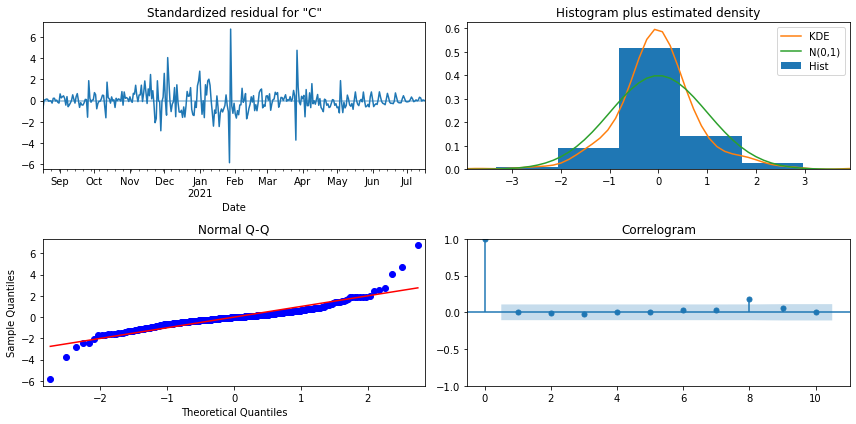

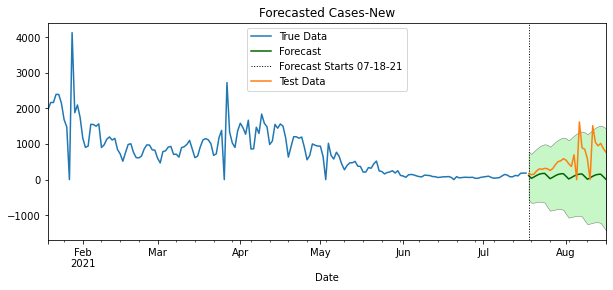

In [71]:
model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         Cases-New   No. Observations:                  381
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -2652.431
Date:                           Wed, 01 Sep 2021   AIC                           5314.861
Time:                                   10:47:03   BIC                           5334.361
Sample:                               08-01-2020   HQIC                          5322.611
                                    - 08-16-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7709      0.068     11.372      0.000       0.638       0.904
ar.L2          0.2108      0.063      3.336      0.001       0.087       0.335
ma.L1         -0.6243      0.058    -10.727      0.000      -0.738      -0.510
ma.S.L7       -0.8255      0.036    -23.010      0.000      -0.896      -0.755
sigma2      1.187e+05   4435.298     26.752      0.000     1.1e+05    1.27e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1693.14
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Cases-New'}, xlabel='Date'>)

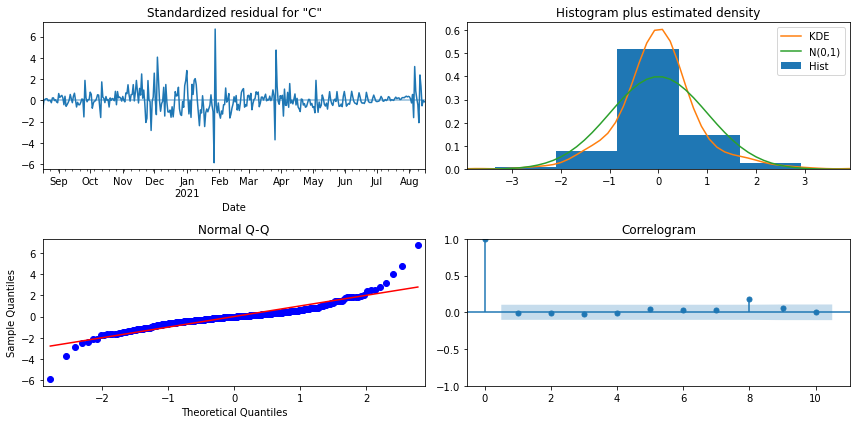

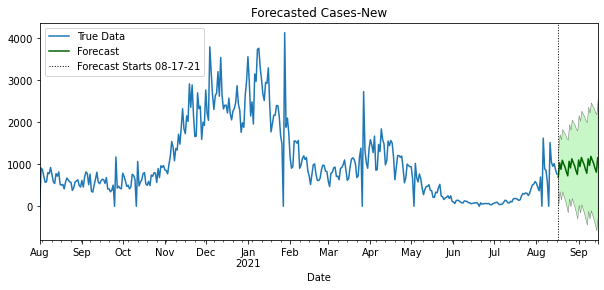

In [72]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
fn.modeling.diagnose_model(model)
fn.modeling.plot_forecast(model, ts)

### MD - Deaths-New

Text(0, 0.5, 'Deaths-New')

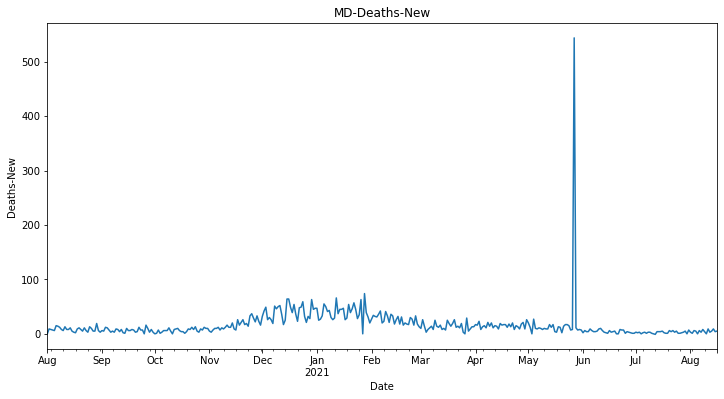

In [73]:
col = 'Deaths-New'
ts = df_state[col].copy()
ax = ts.plot(title=f"{state}-{col}");
ax.set_ylabel(col)

#### Train Test Split

Using a cutoff index of -30, which = 07-18-2021


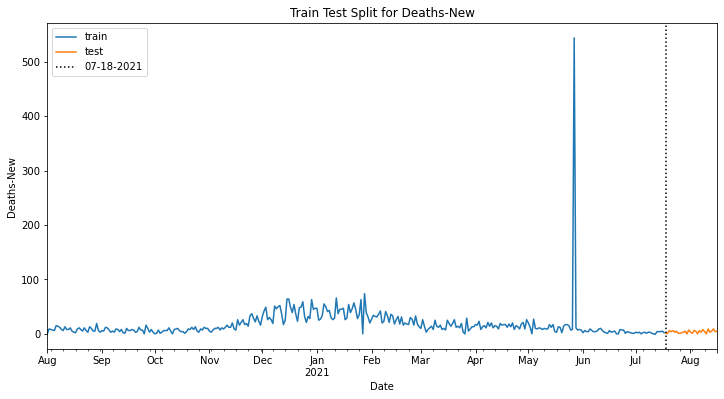

In [74]:
train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

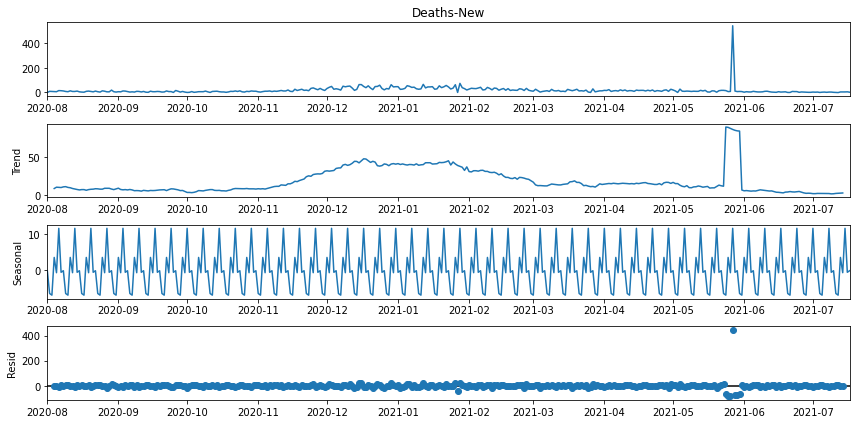

In [75]:
## Get Decomposed time sereis
decomp = tsa.seasonal_decompose(train)
decomp.plot();

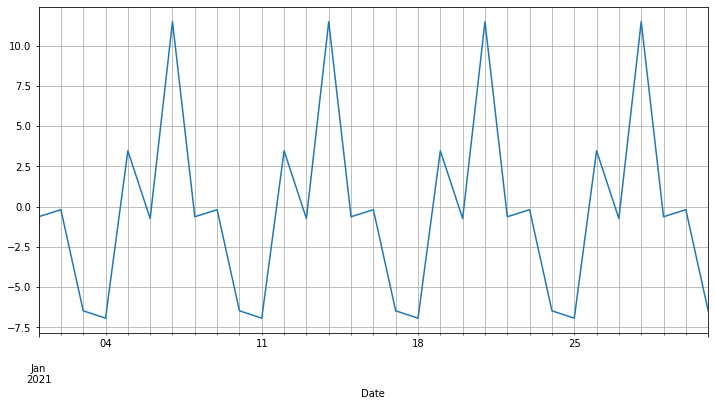

In [76]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-7.601843,13,330,2.377897e-11,True,True


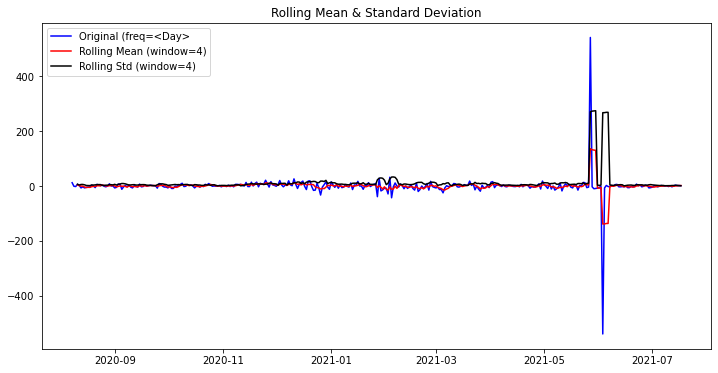

In [77]:
fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

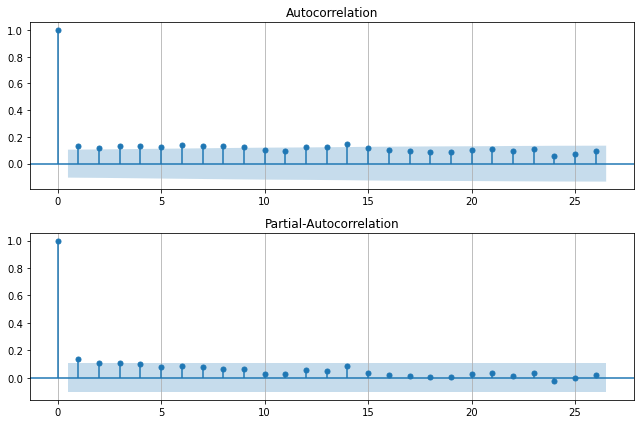

In [78]:
fn.modeling.plot_acf_pacf(train,);

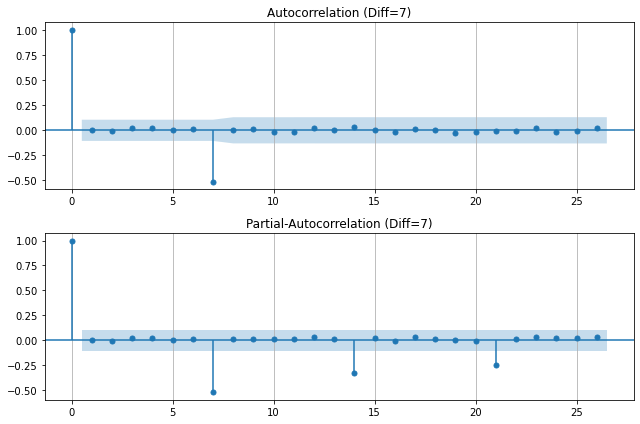

In [79]:
fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [80]:
from pmdarima import auto_arima

auto_model = auto_arima(train,m=7,trace=True,D=1,
                        start_p=0, start_q=0,
                        start_P=0, start_Q=0)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3554.049, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3455.771, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=3375.398, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=3552.052, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=3556.049, Time=0.09 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=3377.246, Time=1.13 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=3455.771, Time=0.23 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=3379.396, Time=1.35 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=3375.868, Time=0.18 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=3375.020, Time=0.54 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=3556.049, Time=0.05 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  351
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -1683.522
Date:                             Wed, 01 Sep 2021   AIC                           3373.044
Time:                                     10:47:29   BIC                           3384.566
Sample:                                          0   HQIC                          3377.633
                                             - 351                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0966      0.033      2.925      0.003       0.032       0.161
ma.S.L7       -0.8804      0.022    -40.517      0.000      -0.923      -0.838
sigma2      1011.9996      8.847    114.391      0.000     994.660    1029.339
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            686862.41
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):              67.58   Skew:                            13.18
Prob(H) (two-sided):                  0.00   Kurtosis:                       220.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Use Best Params for new SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Deaths-New   No. Observations:                  351
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -1646.303
Date:                             Wed, 01 Sep 2021   AIC                           3298.605
Time:                                     10:47:30   BIC                           3310.057
Sample:                                 08-01-2020   HQIC                          3303.170
                                      - 07-17-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1000      0.033      3.060      0.002       0.036       0.164
ma.S.L7       -0.8869      0.023    -38.993      0.000      -0.931      -0.842
sigma2      1034.2850      9.358    110.527      0.000    1015.944    1052.626
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            640845.77
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              44.70   Skew:                            13.04
Prob(H) (two-sided):                  0.00   Kurtosis:                       215.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Deaths-New'}, xlabel='Date'>)

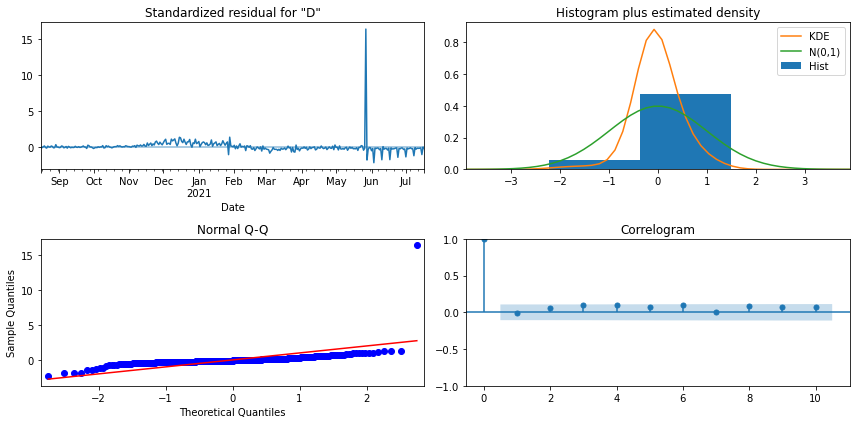

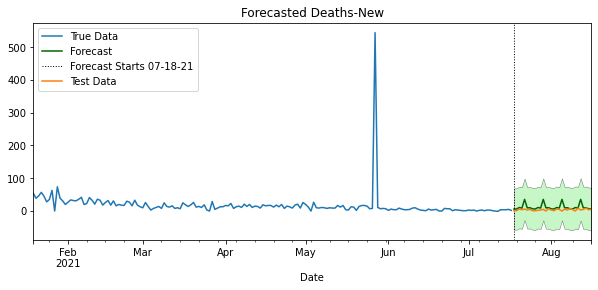

In [81]:
model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Deaths-New   No. Observations:                  381
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -1779.025
Date:                             Wed, 01 Sep 2021   AIC                           3564.051
Time:                                     10:47:31   BIC                           3575.759
Sample:                                 08-01-2020   HQIC                          3568.703
                                      - 08-16-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0931      0.033      2.861      0.004       0.029       0.157
ma.S.L7       -0.8691      0.020    -44.131      0.000      -0.908      -0.830
sigma2       960.4575      7.762    123.737      0.000     945.244     975.671
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            810063.11
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              23.61   Skew:                            13.46
Prob(H) (two-sided):                  0.00   Kurtosis:                       231.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Deaths-New'}, xlabel='Date'>)

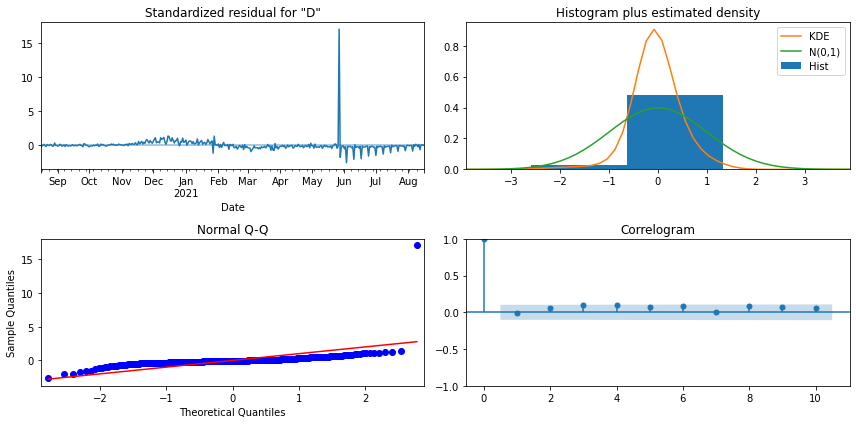

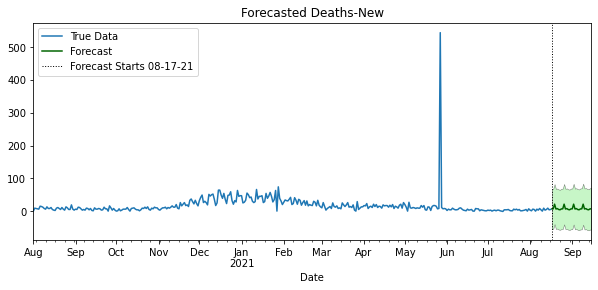

In [82]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
fn.modeling.diagnose_model(model)
fn.modeling.plot_forecast(model, ts)

### MD - Hospitalized Currently

In [83]:
# df_state['Hospitalized Currently']

Text(0, 0.5, 'Hospitalized Currently')

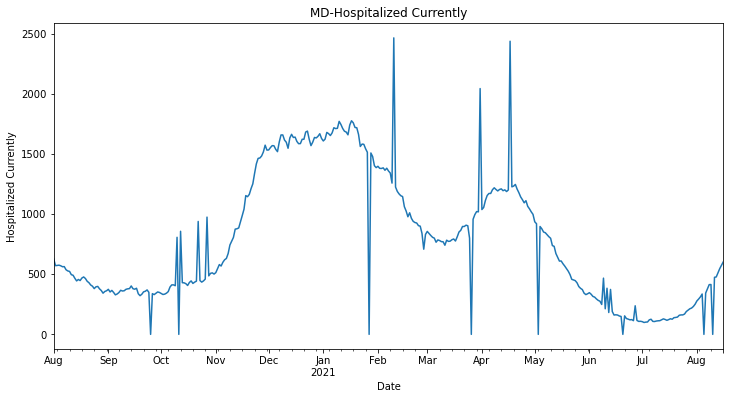

In [84]:
col = 'Hospitalized Currently'
ts = df_state[col].copy()
ax = ts.plot(title=f"{state}-{col}");
ax.set_ylabel(col)

#### Train Test Split

Using a cutoff index of -30, which = 07-18-2021


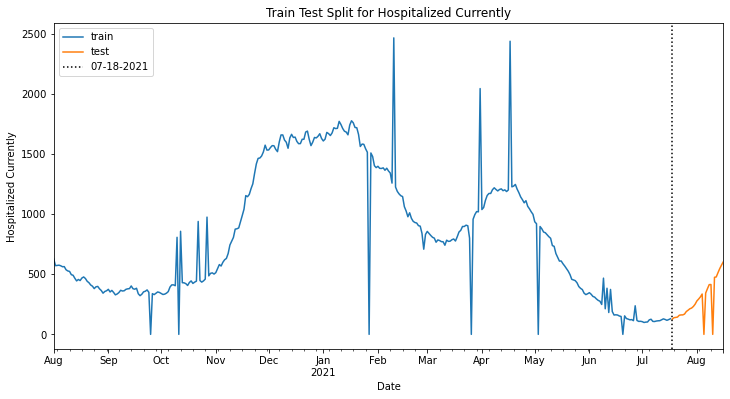

In [85]:
train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

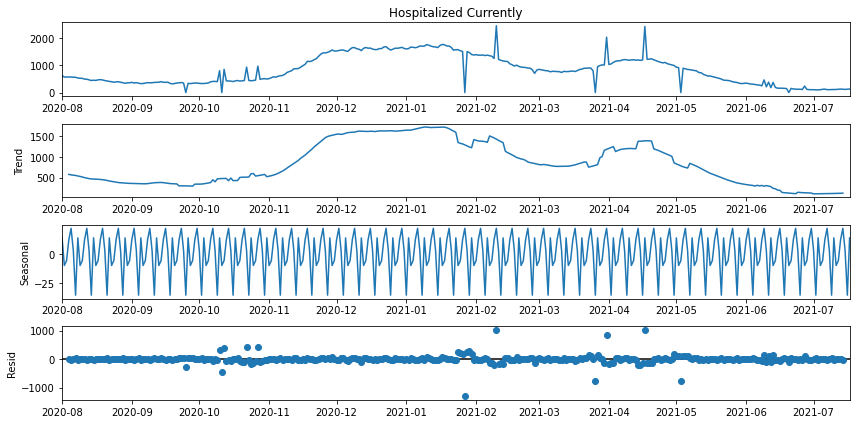

In [86]:
## Get Decomposed time sereis
decomp = tsa.seasonal_decompose(train)
decomp.plot();

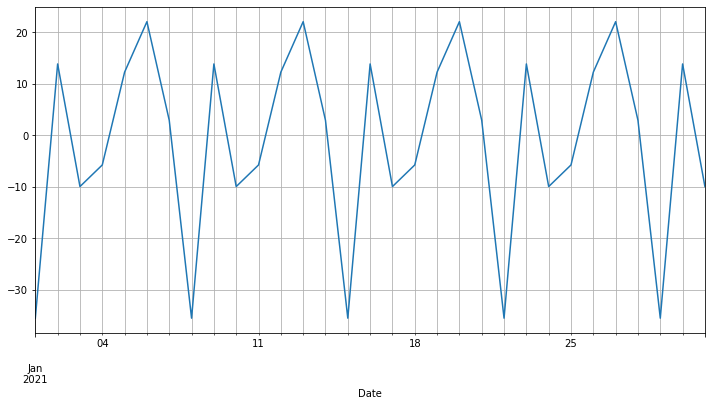

In [87]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-2.791381,16,327,0.059515,False,False


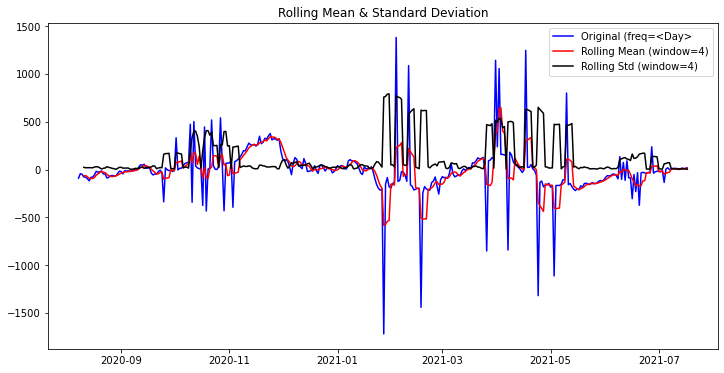

In [88]:
fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

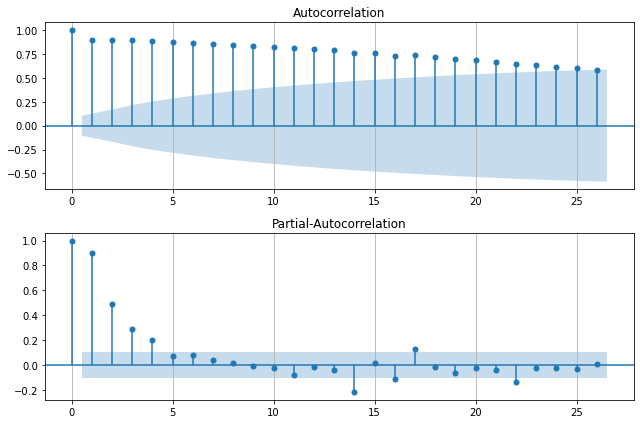

In [89]:
fn.modeling.plot_acf_pacf(train,);

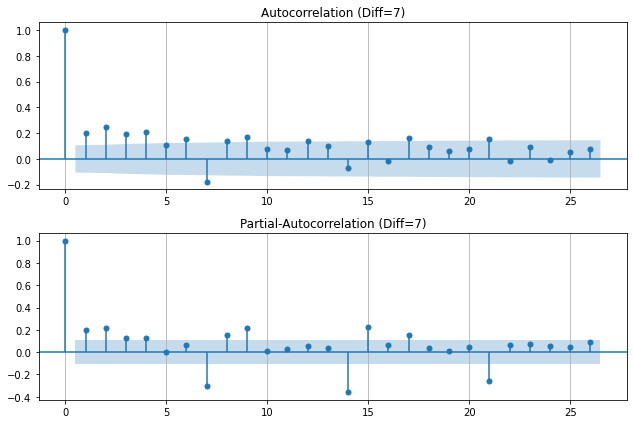

In [90]:
fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [91]:
from pmdarima import auto_arima

auto_model = auto_arima(train,m=7,trace=True,D=1,
                        start_p=0, start_q=0,
                        start_P=0, start_Q=0)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=4968.244, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=4795.866, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=4856.833, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=4729.896, Time=0.30 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=0.85 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=4832.437, Time=0.10 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=4698.794, Time=0.37 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=4767.495, Time=0.18 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=0.95 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.57 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=4686.083, Time=0.55 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=4750.218, Time=0.27 sec
 ARIMA(3,1,0)(2,1,1)[7]             : AIC=inf, Time=1.37 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  351
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 7)   Log Likelihood               -2330.344
Date:                            Wed, 01 Sep 2021   AIC                           4668.689
Time:                                    10:48:25   BIC                           4684.040
Sample:                                         0   HQIC                          4674.804
                                            - 351                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7554      0.032    -23.443      0.000      -0.819      -0.692
ar.S.L7       -0.5634      0.024    -23.755      0.000      -0.610      -0.517
ar.S.L14      -0.4107      0.027    -15.455      0.000      -0.463      -0.359
sigma2      4.605e+04   1279.160     36.002      0.000    4.35e+04    4.86e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):              5125.20
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               3.47   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Use Best Params for new SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             Hospitalized Currently   No. Observations:                  351
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 7)   Log Likelihood               -2240.088
Date:                            Wed, 01 Sep 2021   AIC                           4488.176
Time:                                    10:48:26   BIC                           4503.361
Sample:                                08-01-2020   HQIC                          4494.234
                                     - 07-17-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7548      0.034    -22.507      0.000      -0.821      -0.689
ar.S.L7       -0.5741      0.025    -22.996      0.000      -0.623      -0.525
ar.S.L14      -0.4256      0.027    -15.577      0.000      -0.479      -0.372
sigma2      4.796e+04   1387.972     34.553      0.000    4.52e+04    5.07e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):              4418.88
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               2.87   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Hospitalized Currently'}, xlabel='Date'>)

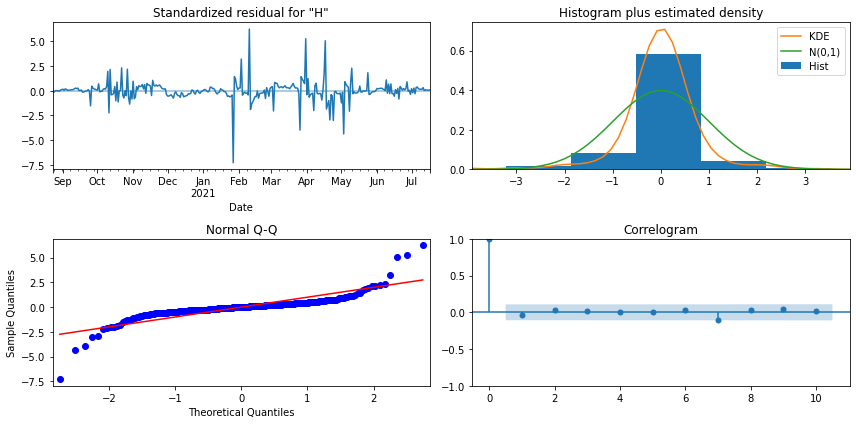

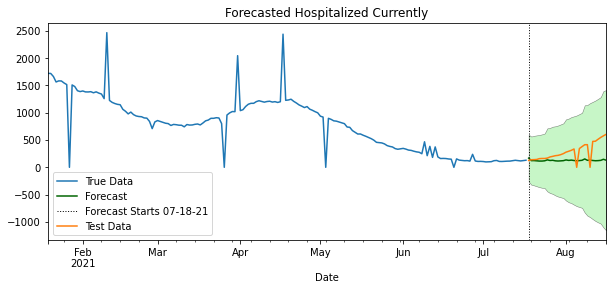

In [92]:
model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             Hospitalized Currently   No. Observations:                  381
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 7)   Log Likelihood               -2433.422
Date:                            Wed, 01 Sep 2021   AIC                           4874.844
Time:                                    10:48:28   BIC                           4890.377
Sample:                                08-01-2020   HQIC                          4881.021
                                     - 08-16-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7550      0.031    -24.066      0.000      -0.816      -0.693
ar.S.L7       -0.5764      0.024    -24.498      0.000      -0.623      -0.530
ar.S.L14      -0.4258      0.026    -16.558      0.000      -0.476      -0.375
sigma2      4.513e+04   1223.527     36.884      0.000    4.27e+04    4.75e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):              5280.26
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                            -0.14
Prob(H) (two-sided):                  0.03   Kurtosis:                        21.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Hospitalized Currently'}, xlabel='Date'>)

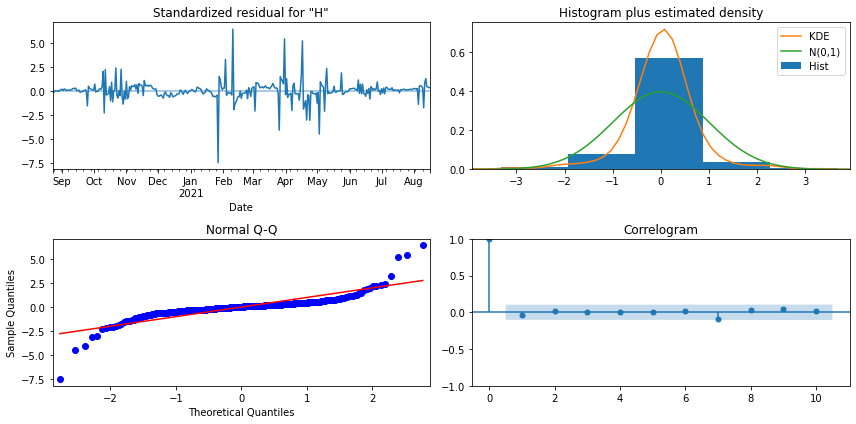

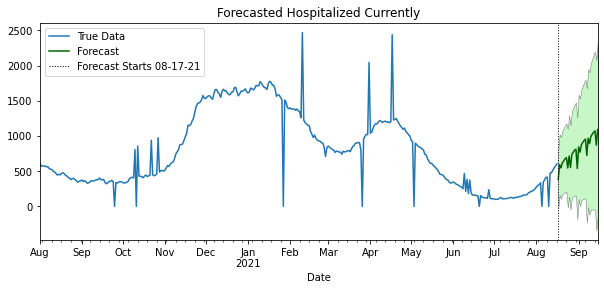

In [93]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
fn.modeling.diagnose_model(model)
fn.modeling.plot_forecast(model, ts)

# APPENDIX

### `def` modeling functions

In [94]:
# def train_test_split_ts(ts,test_size=0.9,split_index=None):
#     """Uses test size by default, split_index overrides it"""
#     if split_index is not None:
#         tts_cutoff = split_index
#     else:
#         tts_cutoff = round(ts.shape[0]*0.9)
#     fmt = "%m-%d-%Y"
#     cutoff_time = ts.index[tts_cutoff]
#     print(f"Using a cutoff index of {tts_cutoff}, which = {cutoff_time.strftime(fmt)}")
    
#       ## Use the tts cutoff to do Train test split and plot
#     train = ts.iloc[:tts_cutoff]
#     test = ts.iloc[tts_cutoff:]

#     ## Plot
#     ax = train.plot(label='train')
#     test.plot(label='test')
#     ax.legend()
#     ax.set(ylabel=ts.name)
#     ax.axvline(cutoff_time,color='k',ls=':',label=cutoff_time.strftime(fmt))
#     ax.legend()
#     ax.set_title(f"Train Test Split for {ts.name}")
#     return train, test


In [95]:
# ## funtionize diagnosing
# def diagnose_model(model): #keep
#     """Takes a fit statsmodels model and displays the .summary 
#     and plots the built-in plot.diagnostics()"""
#     display(model.summary())
#     model.plot_diagnostics()
#     plt.tight_layout()
    
    
# def get_forecast(model,steps=14): #keep
#     forecast = model.get_forecast(steps=steps)
#     forecast_df = forecast.conf_int()
#     forecast_df['Forecast'] = forecast.predicted_mean
#     forecast_df.columns = ['Lower CI','Upper CI','Forecast']
#     return forecast_df


# def plot_forecast(forecast_df,ts,orig_label='True Data',
#                   forecast_label='Forecast',
#                   forecast_steps=30,
#                   last_n_lags=None,figsize=(10,4)):
#     """Takes a forecast_df from get_df_from_pred and optionally 
#     the training/original time series.
    
#     Plots the original ts, the predicted mean and the 
#     confidence invtervals (using fill between)"""
#     if not isinstance(forecast_df,pd.DataFrame):
#         forecast_df = get_forecast(forecast_df,steps=forecast_steps)
        
#     fig,ax = plt.subplots(figsize=figsize)

#     if last_n_lags is None:
#         last_n_lags = len(ts)
        
#     ts.iloc[-last_n_lags:].plot(label='True Data')

    
#     forecast_df['Forecast'].plot(ax=ax,color='darkgreen',label=forecast_label)
#     ax.fill_between(forecast_df.index,
#                     forecast_df['Lower CI'], 
#                     forecast_df['Upper CI'],
#                     color='lightgreen',alpha=0.5,lw=0.5,edgecolor='k')
#     ax.set(title=f'Forecasted {ts.name}')
#     sep = forecast_df.index[0]
#     ax.axvline(sep,label=f"Forecast Starts {sep.strftime('%m-%d-%y')}",lw=1,ls=':',c='k')
#     ax.legend()

#     return fig,ax

    
# def evaluate_model(model,train,test,steps=None,last_n_lags=None):
#     diagnose_model(model)
    
#     if steps is None:
#         steps=len(test)
        
#     forecast_df = get_forecast(model,steps=len(test))
#     fig, ax = plot_forecast(forecast_df,train,last_n_lags=last_n_lags)
    
#     test.plot(ax=ax,label='Test Data')
#     ax.legend()
#     return fig,ax
           
 
